In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 이미지 분할
# 필요한 이미지 다운로드

In [3]:
import urllib.request as req
import zipfile
def downloadImageFromUrl(url,filename,targetDir):
    with req.urlopen(url) as f:
        with open(targetDir+'/'+filename,'wb') as of:
            of.write(f.read())
    zipfile.ZipFile(targetDir+'/'+filename).extractall()           
    
# url = 'https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip'
# import urllib.request as req
# with req.urlopen(url) as f:
#     with open('jena_climate_2009_2016.csv.zip','wb') as of:
#         of.write(f.read())
# import zipfile
# zipfile.ZipFile('./jena_climate_2009_2016.csv.zip').extractall()        

url1 = 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz'  
url2= 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz'

In [5]:
import os
os.mkdir('./image_segmentation')

In [ ]:
!tar -xzvf "/content/drive/MyDrive/annotations.tar.gz"
!tar -xzvf "/content/drive/MyDrive/images.tar.gz"

In [6]:
# downloadImageFromUrl(url1,'images.tar.gz','./image_segmentation')
# zipfile.ZipFile('./image_segmentation/images.tar.gz').extractall()     
# !tar -xvzf './image_segmentation/images.tar.gz'
# downloadImageFromUrl(url2,'annotations.tar.gz','./image_segmentation')

In [7]:
input_dir = 'images/'
target_dir = 'annotations/trimaps/'

In [8]:
pwd

'/content'

In [9]:
os.chdir('/content/image_segmentation')

In [10]:
pwd

'/content/image_segmentation'

In [11]:
input_img_paths = sorted(
    [os.path.join(input_dir,fname) for fname in os.listdir(input_dir) if fname.endswith('.jpg')]    
)

In [12]:
import glob
target_paths =  glob.glob(target_dir+'/*.png')

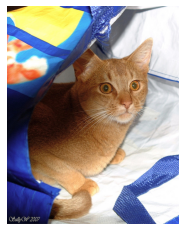

In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.imshow(load_img(input_img_paths[2]))
plt.axis('off')
plt.show()

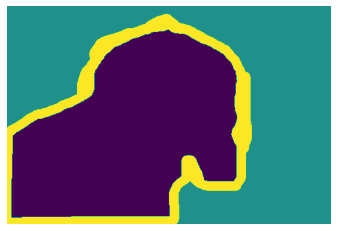

In [14]:
def display_target(target_arrary):
    normalized_array = (target_arrary.astype('uint8')-1)*127
    plt.axis('off')
    plt.imshow(normalized_array[:,:,0])
img = img_to_array(load_img(target_paths[2], color_mode='grayscale'))   
display_target(img)

In [15]:
temp = (img_to_array(load_img(target_paths[0], color_mode='grayscale')).astype('uint8')   -1)*127
temp[0,:,:]
target_paths[0]

'annotations/trimaps/pomeranian_120.png'

In [16]:
# 학습데이터
# 검증데이터
# 테스트 데이터

In [17]:
import numpy as np
import random
img_size = (200,200)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path,target_size=img_size,color_mode='grayscale')        
    )
    img = img.astype('uint8')-1
    return img

In [18]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype='float32')
targets = np.zeros((num_imgs,)+ img_size + (1,), dtype='uint8')
num_imgs

7390

In [19]:
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [20]:
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size+(3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64,3,strides=2, activation='relu', padding = 'same')(x)
    x = layers.Conv2D(64,3, activation='relu', padding = 'same')(x)
    x = layers.Conv2D(128,3,strides=2, activation='relu', padding = 'same')(x)
    x = layers.Conv2D(128,3, activation='relu', padding = 'same')(x)
    x = layers.Conv2D(256,3,strides=2, activation='relu', padding = 'same')(x)
    x = layers.Conv2D(256,3, activation='relu', padding = 'same')(x)
    
    x = layers.Conv2DTranspose(256,3,activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256,3,activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(128,3,activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128,3,activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(64,3,activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64,3,activation='relu', padding='same', strides=2)(x)
    
    outputs = layers.Conv2D(num_classes, 3, activation='softmax',padding='same')(x)
    
    model = keras.Model(inputs,outputs)
    return model

In [23]:
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [24]:
model.compile(optimizer='rmsprop', loss = 'sparse_categorical_crossentropy')
callbacks = [
    keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only=True, patience = 5)
]
history = model.fit(train_input_imgs, train_targets, 
                    epochs=50,callbacks=callbacks,batch_size=64,validation_data=(val_input_imgs,val_targets),verbose=1)

Epoch 1/50
100/100 [==============================] - 82s 662ms/step - loss: 1.0765 - val_loss: 0.9478
Epoch 2/50
100/100 [==============================] - 59s 594ms/step - loss: 0.8877 - val_loss: 0.8404
Epoch 3/50
100/100 [==============================] - 60s 598ms/step - loss: 0.8041 - val_loss: 0.7957
Epoch 4/50
100/100 [==============================] - 60s 597ms/step - loss: 0.7906 - val_loss: 0.7874
Epoch 5/50
100/100 [==============================] - 60s 599ms/step - loss: 0.7917 - val_loss: 0.7783
Epoch 6/50
100/100 [==============================] - 60s 597ms/step - loss: 0.7870 - val_loss: 0.7805
Epoch 7/50
100/100 [==============================] - 59s 593ms/step - loss: 0.7871 - val_loss: 0.7792
Epoch 8/50
100/100 [==============================] - 59s 594ms/step - loss: 0.7876 - val_loss: 0.7817
Epoch 9/50
100/100 [==============================] - 59s 591ms/step - loss: 0.7867 - val_loss: 0.7836
Epoch 10/50
100/100 [==============================] - 59s 591ms/step - l

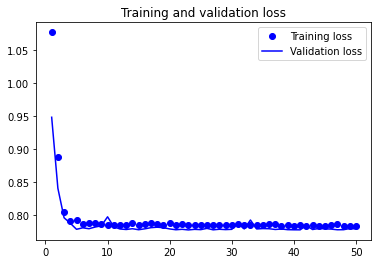

In [27]:
import matplotlib.pyplot as plt
# accuracy = hist.history['accuracy']
# val_accuracy = hist.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
# plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# plt.title('Traning and validation accuracy')
# plt.legend()
# plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("Training and validation loss")
plt.legend()
plt.show()
